In [1]:
import tensorflow as tf
import utils
%matplotlib inline

In [2]:
tf.enable_eager_execution()

In [3]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_raw = utils.get_CIFAR10_data()

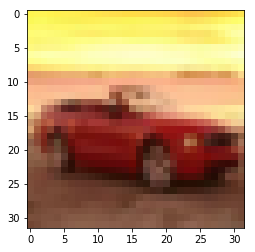

Truth: car


In [4]:
utils.show_random_image(x_test_raw, y_test)